In this notebook I explore the computational potential of a specific kind of neuromodulation observed in the hypothalamus.
Specifically, after an acute stress, chloride extrusion within corticotropin-releasing hormone (CRH) neurons of the hypothalamic paraventricular nucleus (PVN) is disrupted.
This causes chloride to build up inside the cell, which modifies the ion's electrochemical gradient.
As a result, presynaptic GABAergic activity loses its inhibitory effect, and in some situations, can even become excitatory by causing chloride to rush out of the cell ([Hewitt et al., 2010](https://www.nature.com/articles/nn.2274)).
As CRH in turn targets a many regions of the brain, it is positioned to influence high-level cognition in times of an environmental challenge.

In this notebook I model the mechanism and demonstrate an immediate application, of decoding multiple functions in a context-dependent manner.
I examine a simple feedforward network, wherein the weights can take on either excitatory or inhibitory projections. 

Given a feedforward network defined by populations a and b,
the encoders of a are fixed, the projection weights from a to b may be all positive (excitatory) or negative (inhibitory),
solve for the decoders that:
1. Apply the same function across all condition
2. Apply different functions depending on the condition


An essential first step is to characterize what a downstream population of neurons do with this? In other words, how might this effect be leveraged to influence behavior? Could a single layer of decoding weights

In [1]:
# define the model 
import numpy as np
import nengo

n_neurons = 81

model = nengo.Network()
with model:
    ens = nengo.Ensemble(
            radius = 1.,
            dimensions = 1,
            n_neurons = n_neurons,
            max_rates = np.ones((n_neurons,)),
            neuron_type = nengo.RectifiedLinear()
            )

sim = nengo.Simulator(model)

C:\Users\Kathryn\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [5]:
# define inputs and desired outputs
xs = np.random.normal(size=100).reshape(-1,1)
ys1 = xs
ys2 = xs

# compute activities of b under the two conditions
_, A1 = nengo.utils.ensemble.tuning_curves(ens, sim, inputs = xs)
A2 = np.clip( A1+0.5, a_min = 0, a_max = 1. )

ys = np.vstack([ys1,ys2])
A = np.vstack([A1,A2])

print(A.shape)
print(ys.shape)

# nonlinear least squares as CRH neurons are primarily glutamatergic
solver = nengo.solvers.LstsqL2()
#solver = nengo.solvers.NnlsL2()
dec, info1 = solver(A, ys)

ys1_dec = A1 @ dec
ys2_dec = A2 @ dec

(200, 81)
(200, 1)


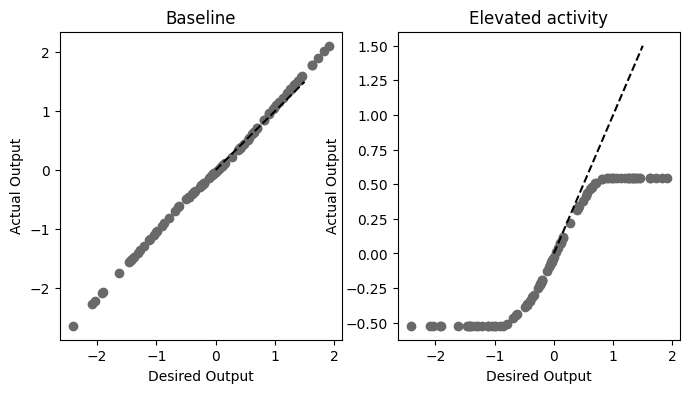

In [6]:
import matplotlib.pyplot as plt
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8.,4.))
ax1.scatter(ys1,ys1_dec,color='dimgray')
ax1.set_title('Baseline')
ax2.scatter(ys2,ys2_dec,color='dimgray')
ax2.set_title('Elevated activity')

for ax in (ax1,ax2):
    ax.plot([0.,1.5],[0.,1.5],color='k',linestyle='--')
    ax.set_xlabel('Desired Output')
    ax.set_ylabel('Actual Output')
plt.show()

In [4]:
tau_synapse = 0.1
tau = 0.1
n_neurons = 1000

with nengo.Network() as model:
    stim = nengo.Node([0])
    u = nengo.Ensemble(n_neurons=500,dimensions=1)
    nengo.Connection(stim,u)
    
    diff = nengo.Ensemble( n_neurons = n_neurons, 
                                dimensions = 3, 
                                radius = 0.1, 
                                max_rates = 50*np.ones((n_neurons,)) 
                                )
    nengo.Connection( u, diff[2], synapse = tau_synapse, transform = tau_synapse )

    # tau f(x) + x
    def recurrent(x):
        x0,x1,u = x
        dx0 = ( - x0 + u ) / tau
        dx1 = ( - x1 - x0 + u ) / tau
        return [tau_synapse * dx0 + x[0], tau_synapse * dx1 + x[1], 0]
        
    nengo.Connection(diff,diff,function=recurrent,synapse=tau_synapse)